# Aquiring and Cleaning Location Data for the City of Indianapolis

In [11]:
# !pip install pandas
# !pip install matplotlib
# !pip install sklearn
# !pip install uszipcode
# !pip install geopy
# !pip install folium

import requests
import pandas as pd
import numpy as np
import types
from uszipcode import SearchEngine #, SimpleZipcode, Zipcode
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from io import StringIO
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium


In [4]:
#Making sure I can see the full Dataframe when I display one.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Our first data source will be the US Postal service which hosts a plethora of data based on zip codes. I was able to download a CSV file containing all the zip codes in the US and then I simply copied the rows over to a new file which I uploaded to my notebook so let's start by importing that to a pandas dataframe and cleaning the data for our purposes.

In [5]:
url = requests.get('https://raw.githubusercontent.com/pvstewar/Food-Availability-Mapping/master/Indianapolis_Zip_Codes.csv')
csv_raw = StringIO(url.text)
df = pd.read_csv(csv_raw)


print(df.shape)
df.head(8)


(65, 14)


,zip,type,decommissioned,primary_city,acceptable_cities,unacceptable_cities,state,county,area_codes,world_region,country,latitude,longitude,irs_estimated_population_2015
0,46201,STANDARD,0,Indianapolis,NaN,NaN,IN,Marion County,317.0,NaN,US,39.77,-86.11,26410
1,46202,STANDARD,0,Indianapolis,NaN,NaN,IN,Marion County,765317.0,NaN,US,39.77,-86.14,11880
2,46203,STANDARD,0,Indianapolis,NaN,NaN,IN,Marion County,317.0,NaN,US,39.74,-86.10,33150
3,46204,STANDARD,0,Indianapolis,NaN,NaN,IN,Marion County,317765.0,NaN,US,39.77,-86.16,4720
4,46205,STANDARD,0,Indianapolis,NaN,Uptown,IN,Marion County,317.0,NaN,US,39.83,-86.13,23730
5,46206,PO BOX,0,Indianapolis,NaN,NaN,IN,Marion County,317.0,NaN,US,39.77,-86.14,589
6,46207,PO BOX,0,Indianapolis,NaN,NaN,IN,Marion County,317.0,NaN,US,39.77,-86.14,0
7,46208,STANDARD,0,Indianapolis,Rocky Ripple,NaN,IN,Marion County,317.0,NaN,US,39.82,-86.17,16610


Now clean this data up a bit and just keep the info we think might be useful for this project:

In [6]:
df = df[df.type == 'STANDARD']#get rid of non-geographic zip codes
df_clean = df[['zip', 'primary_city', 'latitude', 'longitude','irs_estimated_population_2015']].copy()
df_clean.head(8)

,zip,primary_city,latitude,longitude,irs_estimated_population_2015
0,46201,Indianapolis,39.77,-86.11,26410
1,46202,Indianapolis,39.77,-86.14,11880
2,46203,Indianapolis,39.74,-86.10,33150
3,46204,Indianapolis,39.77,-86.16,4720
4,46205,Indianapolis,39.83,-86.13,23730
7,46208,Indianapolis,39.82,-86.17,16610
12,46214,Indianapolis,39.79,-86.29,22310
13,46216,Indianapolis,39.87,-86.01,1780


Now that we have our baseline list of zipcodes for the city of Indianapolis we can use a python library called uszipcode which contains more detailed location data as well as useful demographic info on each zip code in the US.

In [7]:
#Using uszipcode library
lst_inzip =[]
search = SearchEngine()
zip_list = df_clean['zip'].values.tolist()
for z in zip_list:
    l = search.by_zipcode(z)
    l = l.to_dict(include_null=True)
    lst_inzip.append(l)
df_inzip = pd.DataFrame(lst_inzip)

df_inzip.head()

Download C:\Users\pvste\.uszipcode\simple_db.sqlite from https://github.com/MacHu-GWU/uszipcode-project/releases/download/1.0.1.db/simple_db.sqlite ...
  1.00 MB downloaded ...
  2.00 MB downloaded ...
  3.00 MB downloaded ...
  4.00 MB downloaded ...
  5.00 MB downloaded ...
  6.00 MB downloaded ...
  7.00 MB downloaded ...
  8.00 MB downloaded ...
  9.00 MB downloaded ...
  10.00 MB downloaded ...
  11.00 MB downloaded ...
  Complete!


,zipcode,zipcode_type,major_city,post_office_city,common_city_list,county,state,lat,lng,timezone,radius_in_miles,area_code_list,population,population_density,land_area_in_sqmi,water_area_in_sqmi,housing_units,occupied_housing_units,median_home_value,median_household_income,bounds_west,bounds_east,bounds_north,bounds_south
0,46201,STANDARD,Indianapolis,"Indianapolis, IN",[Indianapolis],Marion County,IN,39.77,-86.11,America/Indiana/Indianapolis,2.0,317,30962.0,5542.0,5.59,0.00,16868.0,11977.0,68500.0,26391.0,-86.136878,-86.082971,39.791819,39.757465
1,46202,STANDARD,Indianapolis,"Indianapolis, IN",[Indianapolis],Marion County,IN,39.77,-86.14,America/Indiana/Indianapolis,3.0,"765,317",16335.0,2927.0,5.58,0.16,9825.0,8149.0,168900.0,31698.0,-86.197006,-86.131776,39.800784,39.760050
2,46203,STANDARD,Indianapolis,"Indianapolis, IN",[Indianapolis],Marion County,IN,39.74,-86.10,America/Indiana/Indianapolis,4.0,317,38950.0,2806.0,13.88,0.00,17688.0,14870.0,75000.0,30481.0,-86.151173,-86.044969,39.763024,39.694590
3,46204,STANDARD,Indianapolis,"Indianapolis, IN",[Indianapolis],Marion County,IN,39.77,-86.16,America/Indiana/Indianapolis,1.0,"317,765",5125.0,4570.0,1.12,0.01,3033.0,2459.0,264700.0,39826.0,-86.175804,-86.141726,39.784309,39.761219
4,46205,STANDARD,Indianapolis,"Indianapolis, IN",[Indianapolis],Marion County,IN,39.83,-86.13,America/Indiana/Indianapolis,2.0,317,25356.0,4050.0,6.26,0.08,14175.0,11194.0,118100.0,36429.0,-86.157192,-86.100831,39.848206,39.797326


In [8]:
#Lets do some clean up on our df
print(df_inzip.shape)
inzip2 = df_inzip[['zipcode', 'bounds_east', 'bounds_north', 'bounds_south', 'bounds_west', 'county', 'common_city_list', 'housing_units', 'land_area_in_sqmi', 'lat', 'lng', 'median_home_value', 'median_household_income', 'occupied_housing_units', 'population', 'population_density']].copy()
inzip2.rename(columns={"common_city_list": "cities", "lat": "Latitude", "lng":"Longitude"}, inplace = True)
inzip2.dropna(axis=0,inplace=True)
print(df_inzip.shape)
inzip2.head(8)

(38, 24)
(38, 24)


,zipcode,bounds_east,bounds_north,bounds_south,bounds_west,county,cities,housing_units,land_area_in_sqmi,Latitude,Longitude,median_home_value,median_household_income,occupied_housing_units,population,population_density
0,46201,-86.082971,39.791819,39.757465,-86.136878,Marion County,[Indianapolis],16868.0,5.59,39.77,-86.11,68500.0,26391.0,11977.0,30962.0,5542.0
1,46202,-86.131776,39.800784,39.760050,-86.197006,Marion County,[Indianapolis],9825.0,5.58,39.77,-86.14,168900.0,31698.0,8149.0,16335.0,2927.0
2,46203,-86.044969,39.763024,39.694590,-86.151173,Marion County,[Indianapolis],17688.0,13.88,39.74,-86.10,75000.0,30481.0,14870.0,38950.0,2806.0
3,46204,-86.141726,39.784309,39.761219,-86.175804,Marion County,[Indianapolis],3033.0,1.12,39.77,-86.16,264700.0,39826.0,2459.0,5125.0,4570.0
4,46205,-86.100831,39.848206,39.797326,-86.157192,Marion County,[Indianapolis],14175.0,6.26,39.83,-86.13,118100.0,36429.0,11194.0,25356.0,4050.0
5,46208,-86.153078,39.871131,39.795494,-86.196806,Marion County,"[Indianapolis, Rocky Ripple]",11993.0,6.71,39.82,-86.17,108300.0,31999.0,8879.0,22239.0,3312.0
6,46214,-86.266848,39.823436,39.760697,-86.310698,Marion County,"[Indianapolis, Eagle Creek]",11881.0,7.11,39.79,-86.29,116700.0,41095.0,10824.0,24306.0,3420.0
7,46216,-85.989154,39.891035,39.844730,-86.039264,Marion County,[Indianapolis],1065.0,3.49,39.87,-86.01,137900.0,44479.0,966.0,1697.0,486.0


Now that we have a baseline df with zipcodes and demographic info let's shift to using foursquare and folium to gather venue info and visualize on a map.

In [12]:
#Find the center point of our map of Indy
address = 'Indianapolis, IN'

geolocator = Nominatim(user_agent="CN_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Indianapolis are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of Indianapolis are 39.7683331, -86.1583502.


Lets create a basic folium map showing each or our zip codes on a map so we can get familliar with the city of Indianapolis.

In [9]:

map_indy = folium.Map(location=[latitude, longitude], zoom_start=10)
# add markers to map
for lat, lng, label in zip(inzip2['Latitude'], inzip2['Longitude'], inzip2['zipcode']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
         fill_opacity=0.7,
        parse_html=False).add_to(map_indy)  
   

map_indy

In [13]:
CLIENT_ID = 'EXWUKLPSYSG1IDXEJCDEHIWOGOSKYXVIIJFLZIYTFR1PK2JY' # your Foursquare ID
CLIENT_SECRET = '3TCGO4AZIR2V0ESZN4PPAEYPVEC1JDXFQUSOYOHG3RMKNCAZ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EXWUKLPSYSG1IDXEJCDEHIWOGOSKYXVIIJFLZIYTFR1PK2JY
CLIENT_SECRET:3TCGO4AZIR2V0ESZN4PPAEYPVEC1JDXFQUSOYOHG3RMKNCAZ


Since we want to gather as much data as we can about Grocery access in Indianapolis for each zip code, I had to find the best way to formulate the foursquare request.  I found that we could use the API to request info based on creating a virtual grid for each zipcode where the API accespts a search bound by the Southwest and Northeast corner of the search area. With our zipcode info we have a listing for the north, south, east and west boundries for each zip code so here I will combine those to create a column to use with the API.

In [14]:
inzip2['Southwest Bound'] = inzip2['bounds_south'].astype(str) +","+ inzip2['bounds_west'].astype(str)
inzip2['Northeast Bound'] = inzip2['bounds_north'].astype(str) +","+ inzip2['bounds_east'].astype(str)
inzip2.head()

,zipcode,bounds_east,bounds_north,bounds_south,bounds_west,county,cities,housing_units,land_area_in_sqmi,Latitude,Longitude,median_home_value,median_household_income,occupied_housing_units,population,population_density,Southwest Bound,Northeast Bound
0,46201,-86.082971,39.791819,39.757465,-86.136878,Marion County,[Indianapolis],16868.0,5.59,39.77,-86.11,68500.0,26391.0,11977.0,30962.0,5542.0,"39.757465,-86.136878","39.791819,-86.082971"
1,46202,-86.131776,39.800784,39.760050,-86.197006,Marion County,[Indianapolis],9825.0,5.58,39.77,-86.14,168900.0,31698.0,8149.0,16335.0,2927.0,"39.76005,-86.197006","39.800784,-86.131776"
2,46203,-86.044969,39.763024,39.694590,-86.151173,Marion County,[Indianapolis],17688.0,13.88,39.74,-86.10,75000.0,30481.0,14870.0,38950.0,2806.0,"39.69459,-86.151173","39.763024,-86.044969"
3,46204,-86.141726,39.784309,39.761219,-86.175804,Marion County,[Indianapolis],3033.0,1.12,39.77,-86.16,264700.0,39826.0,2459.0,5125.0,4570.0,"39.761219,-86.175804","39.784309,-86.141726"
4,46205,-86.100831,39.848206,39.797326,-86.157192,Marion County,[Indianapolis],14175.0,6.26,39.83,-86.13,118100.0,36429.0,11194.0,25356.0,4050.0,"39.797326,-86.157192","39.848206,-86.100831"


Now we can use the coordinate data to create our url to gather the foursquare data.  We are able to restrict the search by categories so I looked up the category id for Grocery Store and Supermarket so restrict our search to the most pertinent venues.

In [15]:
#Now to create the function to get the list of venues for our selected locations
#this uses Grocery store (cat id 4bf58dd8d48988d118951735) and supermarket (cat id 52f2ab2ebcbc57f1066b8b46)
def getCategoryVenues(names, southwest, northeast, LIMIT=50):
    
    venues_list=[]
    for name, sw_bound, ne_bound in zip(names, southwest, northeast):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?sw={}&ne={}&categoryId=4bf58dd8d48988d118951735,52f2ab2ebcbc57f1066b8b46&limit={}&intent=browse&client_id={}&client_secret={}&v={}'.format(
            sw_bound,
            ne_bound,
            LIMIT,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
        # make the GET request
        results = requests.get(url).json()["response"]["venues"]
       
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            sw_bound, 
            ne_bound, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng']) for v in results])

    nearby_cat_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_cat_venues.columns = ['Zipcode', 
                  'Southwest Coordinates', 
                  'Northeast Coordinates', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',]

    return(nearby_cat_venues)

In [16]:
#now we can use the above function to create a venue list for Indy
Indy_Grocery_venues = getCategoryVenues(names=inzip2['zipcode'],
                                southwest=inzip2['Southwest Bound'],
                                northeast=inzip2['Northeast Bound']
                                )


46201
46202
46203
46204
46205
46208
46214
46216
46217
46218
46219
46220
46221
46222
46224
46225
46226
46227
46228
46229
46231
46234
46235
46236
46237
46239
46240
46241
46250
46254
46256
46259
46260
46268
46278
46280
46290


This produces a dataframe with almost 400 venues.  Some of the venues were repetative, where some of the large chain stores had multiple "venues" but in reality were only a single venue. Most of the lines below deal with those issues and the result is a cleaner list. Another issue is that there are many duplicates due to the fact that the API allows for a search of a geographical square for each zipcode but the actual zip codes are irregular shapes. For the purposes of this project I think that is an OK problem to have in some parts of the analysis where we are really concerned with proximity to grocery stores on the individual zip code level but I may have to remove the duplicates for other parts of the analysis.

In [17]:
print(Indy_Grocery_venues.shape)
# to cut back on duplicate hits
igv = []
igv = Indy_Grocery_venues.copy()
pd.to_numeric(igv['Venue Latitude'])
pd.to_numeric(igv['Venue Longitude'])
igv = igv.round({'Venue Latitude':3, 'Venue Longitude':3})
igv = igv[~igv.Venue.str.contains("Pickup and Delivery")]
igv = igv[~igv.Venue.str.contains("Pickup & Delivery")]
igv = igv[~igv.Venue.str.contains("Gas Station")]
igv = igv[~igv.Venue.str.contains("Pharmacy")]
print(igv.shape)
igv

(348, 6)
(315, 6)


,Zipcode,Southwest Coordinates,Northeast Coordinates,Venue,Venue Latitude,Venue Longitude
0,46201,"39.757465,-86.136878","39.791819,-86.082971",Kroger,39.779,-86.093
1,46201,"39.757465,-86.136878","39.791819,-86.082971",Kroger,39.758,-86.115
2,46201,"39.757465,-86.136878","39.791819,-86.082971",Safeway,39.789,-86.084
3,46201,"39.757465,-86.136878","39.791819,-86.082971",Walmart Grocery Pickup,39.759,-86.111
4,46201,"39.757465,-86.136878","39.791819,-86.082971",Bienvenidos Supermercados,39.772,-86.107
5,46201,"39.757465,-86.136878","39.791819,-86.082971",Save-A-Lot,39.768,-86.103
6,46201,"39.757465,-86.136878","39.791819,-86.082971",2 Amigos Mexican Grocery,39.761,-86.113
7,46201,"39.757465,-86.136878","39.791819,-86.082971",Denise Scarbrough,39.778,-86.086
8,46201,"39.757465,-86.136878","39.791819,-86.082971",Kroger Grocery Delivery and Pickup,39.780,-86.094
9,46202,"39.76005,-86.197006","39.800784,-86.131776",Whole Foods Market,39.768,-86.152


In [23]:
#Check for duplicates
igv_dupes = igv[igv.duplicated(subset = ['Venue','Venue Latitude','Venue Longitude'], keep=False)]
print(igv_dupes.shape)
igv_dupes

(205, 6)


,Zipcode,Southwest Coordinates,Northeast Coordinates,Venue,Venue Latitude,Venue Longitude
1,46201,"39.757465,-86.136878","39.791819,-86.082971",Kroger,39.758,-86.115
2,46201,"39.757465,-86.136878","39.791819,-86.082971",Safeway,39.789,-86.084
3,46201,"39.757465,-86.136878","39.791819,-86.082971",Walmart Grocery Pickup,39.759,-86.111
6,46201,"39.757465,-86.136878","39.791819,-86.082971",2 Amigos Mexican Grocery,39.761,-86.113
7,46201,"39.757465,-86.136878","39.791819,-86.082971",Denise Scarbrough,39.778,-86.086
9,46202,"39.76005,-86.197006","39.800784,-86.131776",Whole Foods Market,39.768,-86.152
10,46202,"39.76005,-86.197006","39.800784,-86.131776",Kroger,39.774,-86.163
12,46202,"39.76005,-86.197006","39.800784,-86.131776",Needler's Fresh Market,39.772,-86.152
13,46202,"39.76005,-86.197006","39.800784,-86.131776",Amberson Coffee & Grocer,39.761,-86.146
14,46202,"39.76005,-86.197006","39.800784,-86.131776",Angelo's Truck and Railroad Salvage,39.764,-86.145


In [25]:
#For purposes of overall venue list for the city we can drop the duplicates that appear in multiple zip codes
print(f"Venues before dedup {igv.shape[0]}")
dedupe_igv = igv.drop_duplicates(subset = ['Venue','Venue Latitude','Venue Longitude'], keep='first')
print(f"Venues after dedup {dedupe_igv.shape[0]}")

Venues before dedup 315
Venues after dedup 206


## Now to show our stores on a map and get a visual of all the grocery stores in Indy

In [26]:
map_indy_Groc = folium.Map(location=[latitude, longitude], zoom_start=10)
# add markers to map
for lat, lng, label in zip(dedupe_igv['Venue Latitude'], dedupe_igv['Venue Longitude'], dedupe_igv['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
         fill_opacity=0.7,
        parse_html=False).add_to(map_indy_Groc)  
   

map_indy_Groc 

The above map is a simple visual of all of our venues but for a better illustration lets create a heatmap that will show us by color where the high and low concentrations are.

In [27]:
heat_list = dedupe_igv
print(heat_list.shape)
hl2 = heat_list[['Venue Latitude','Venue Longitude']].copy()
list_heat = hl2.values.tolist()


(206, 6)


In [32]:
import folium.plugins as plugins
from folium.plugins import HeatMap
Groc_heat = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, label in zip(inzip2['Latitude'], inzip2['Longitude'], inzip2['zipcode']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
         fill_opacity=0.7,
        parse_html=False).add_to(Groc_heat)

plugins.HeatMap(list_heat, radius = 30, min_opacity = 0.5, max_zoom = 13).add_to(Groc_heat)
    
Groc_heat

Next let's start looking at how to answer our main question here of how grocery access varies from zip code to zip code in Indianapolis. First I want to make a distinction in the data between the types of stores. This is hard to do since we don't have a lot of data about the individual venues but since I'm familiar with Indy I can definitely draw a general line between the large chain stores that have a wide variety of food available versus some of the smaller local or chain stores that are likely to have a much more limited selection. We'll take a look at that later to see if we that distinction provides any additional clerity.

In [39]:
#add a column to distinguish large chain stores from smaller stores using 1 hot encoding
lrg = ('Kroger','Safeway','Walmart','Whole Foods','Aldi','ALDI','Meijer','Trader Joe')
dedupe_igv['Large_Chain'] = dedupe_igv['Venue'].str.findall('|'.join(lrg)).str.len()
print(dedupe_igv.shape)
dedupe_igv.head(10)


(206, 7)


C:\Users\pvste\AppData\Local\Temp\ipykernel_26696\2290240915.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dedupe_igv['Large_Chain'] = dedupe_igv['Venue'].str.findall('|'.join(lrg)).str.len()


,Zipcode,Southwest Coordinates,Northeast Coordinates,Venue,Venue Latitude,Venue Longitude,Large_Chain
0,46201,"39.757465,-86.136878","39.791819,-86.082971",Kroger,39.779,-86.093,1
1,46201,"39.757465,-86.136878","39.791819,-86.082971",Kroger,39.758,-86.115,1
2,46201,"39.757465,-86.136878","39.791819,-86.082971",Safeway,39.789,-86.084,1
3,46201,"39.757465,-86.136878","39.791819,-86.082971",Walmart Grocery Pickup,39.759,-86.111,1
4,46201,"39.757465,-86.136878","39.791819,-86.082971",Bienvenidos Supermercados,39.772,-86.107,0
5,46201,"39.757465,-86.136878","39.791819,-86.082971",Save-A-Lot,39.768,-86.103,0
6,46201,"39.757465,-86.136878","39.791819,-86.082971",2 Amigos Mexican Grocery,39.761,-86.113,0
7,46201,"39.757465,-86.136878","39.791819,-86.082971",Denise Scarbrough,39.778,-86.086,0
8,46201,"39.757465,-86.136878","39.791819,-86.082971",Kroger Grocery Delivery and Pickup,39.780,-86.094,1
9,46202,"39.76005,-86.197006","39.800784,-86.131776",Whole Foods Market,39.768,-86.152,1


### Now Lets see what our heatmap looks like with only the large chains.

In [40]:
Large_set = dedupe_igv[dedupe_igv.Large_Chain != 0]
print(Large_set.shape)
ls1 = Large_set[['Venue Latitude','Venue Longitude']].copy()
lrg_heat = ls1.values.tolist()


(92, 7)


In [41]:

Lrgm = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, label in zip(inzip2['Latitude'], inzip2['Longitude'], inzip2['zipcode']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
         fill_opacity=0.7,
        parse_html=False).add_to(Lrgm)

plugins.HeatMap(lrg_heat, radius = 30, min_opacity = 0.5, max_zoom = 13).add_to(Lrgm)
    
Lrgm

While both maps illustrate where some of the food deserts may be when we look at the second map we see clearly the way that the larger chains map well to highways and major intersections with large areas of white in between. Next lets create new dataframes to look at the ratio of stores to people in each zip code.

In [42]:
#create a new df to represent the store count per zip code.
Indy_groc_count = dedupe_igv.Zipcode.value_counts().reset_index().rename(columns={'index': 'Zipcode', 'Zipcode': 'Total Store Count'})
igv_lc = dedupe_igv[['Zipcode','Large_Chain']].copy()
igv_lc = igv_lc.groupby('Zipcode').sum().reset_index()
print(igv_lc.shape)
print(Indy_groc_count.shape)
igc_1 = pd.merge(Indy_groc_count,igv_lc, on='Zipcode')
igc_1



(31, 2)
(31, 2)


,Zipcode,Total Store Count,Large_Chain
0,46203,18,10
1,46220,16,9
2,46227,11,2
3,46219,11,4
4,46222,11,3
5,46221,11,6
6,46268,11,5
7,46254,10,2
8,46250,10,1
9,46201,9,5


In [43]:
igc_1.rename(columns = {'Zipcode':'zipcode'}, inplace = True)
inzip3 = inzip2.merge(igc_1, how='left')
inzip3.fillna({'Total Store Count':0,'Large_Chain':0}, inplace=True)
inzip3[['Total Store Count','land_area_in_sqmi','Large_Chain','population_density']] = inzip3[['Total Store Count','land_area_in_sqmi','Large_Chain','population_density']].apply(pd.to_numeric)

inzip3

,zipcode,bounds_east,bounds_north,bounds_south,bounds_west,county,cities,housing_units,land_area_in_sqmi,Latitude,Longitude,median_home_value,median_household_income,occupied_housing_units,population,population_density,Southwest Bound,Northeast Bound,Total Store Count,Large_Chain
0,46201,-86.082971,39.791819,39.757465,-86.136878,Marion County,[Indianapolis],16868.0,5.59,39.77,-86.11,68500.0,26391.0,11977.0,30962.0,5542.0,"39.757465,-86.136878","39.791819,-86.082971",9.0,5.0
1,46202,-86.131776,39.800784,39.760050,-86.197006,Marion County,[Indianapolis],9825.0,5.58,39.77,-86.14,168900.0,31698.0,8149.0,16335.0,2927.0,"39.76005,-86.197006","39.800784,-86.131776",9.0,3.0
2,46203,-86.044969,39.763024,39.694590,-86.151173,Marion County,[Indianapolis],17688.0,13.88,39.74,-86.10,75000.0,30481.0,14870.0,38950.0,2806.0,"39.69459,-86.151173","39.763024,-86.044969",18.0,10.0
3,46204,-86.141726,39.784309,39.761219,-86.175804,Marion County,[Indianapolis],3033.0,1.12,39.77,-86.16,264700.0,39826.0,2459.0,5125.0,4570.0,"39.761219,-86.175804","39.784309,-86.141726",0.0,0.0
4,46205,-86.100831,39.848206,39.797326,-86.157192,Marion County,[Indianapolis],14175.0,6.26,39.83,-86.13,118100.0,36429.0,11194.0,25356.0,4050.0,"39.797326,-86.157192","39.848206,-86.100831",5.0,1.0
5,46208,-86.153078,39.871131,39.795494,-86.196806,Marion County,"[Indianapolis, Rocky Ripple]",11993.0,6.71,39.82,-86.17,108300.0,31999.0,8879.0,22239.0,3312.0,"39.795494,-86.196806","39.871131,-86.153078",6.0,2.0
6,46214,-86.266848,39.823436,39.760697,-86.310698,Marion County,"[Indianapolis, Eagle Creek]",11881.0,7.11,39.79,-86.29,116700.0,41095.0,10824.0,24306.0,3420.0,"39.760697,-86.310698","39.823436,-86.266848",2.0,2.0
7,46216,-85.989154,39.891035,39.844730,-86.039264,Marion County,[Indianapolis],1065.0,3.49,39.87,-86.01,137900.0,44479.0,966.0,1697.0,486.0,"39.84473,-86.039264","39.891035,-85.989154",2.0,0.0
8,46217,-86.156214,39.722456,39.633744,-86.245919,Marion County,"[Indianapolis, Southport]",12039.0,21.47,39.67,-86.19,131600.0,60254.0,11424.0,29358.0,1367.0,"39.633744,-86.245919","39.722456,-86.156214",5.0,2.0
9,46218,-86.064058,39.827562,39.786770,-86.138001,Marion County,[Indianapolis],14978.0,9.44,39.81,-86.10,60100.0,25666.0,11573.0,29028.0,3077.0,"39.78677,-86.138001","39.827562,-86.064058",1.0,1.0


### Now that we have our venue info in our main data frame let's look at a bar chart to see how it breaks down.

<AxesSubplot:xlabel='zipcode'>

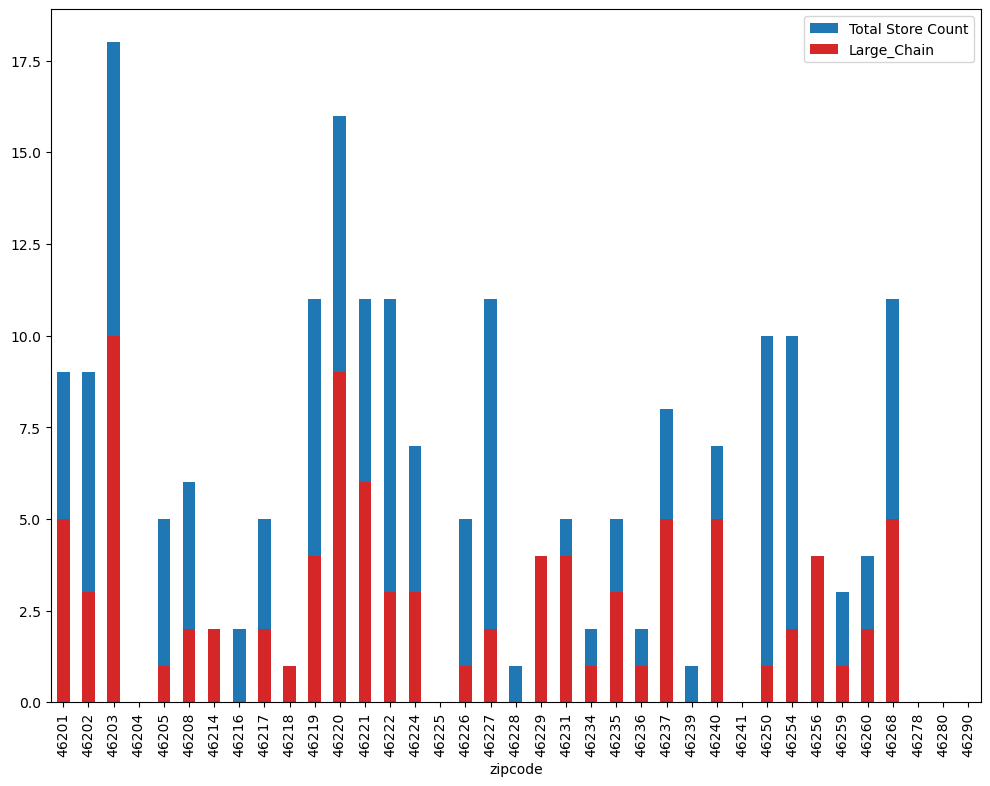

In [44]:
#lets visualize our store count by zip code
#figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

ax = inzip3.plot(x="zipcode", y="Total Store Count", kind="bar")
inzip3.plot(x="zipcode", y="Large_Chain", kind="bar", ax=ax, color="C3")


We can see a big difference from one zip code to another... Now lets think of this on more personal terms and add numbers on how many stores per square mile in each zip code and also the heart of the question, what is the proportion of people to store per square mile in each zip.

In [45]:

inzip3['stores per sqmi'] = inzip3['Total Store Count']/inzip3['land_area_in_sqmi']
inzip3['large stores per sqmi'] = inzip3['Large_Chain']/inzip3['land_area_in_sqmi']
inzip3['store pop ratio'] = inzip3['population_density']/inzip3['stores per sqmi']
inzip3['large store pop ratio'] = inzip3['population_density']/inzip3['large stores per sqmi']
inzip3 = inzip3.round({'store pop ratio':3, 'large store pop ratio':3})
inzip3.replace([np.inf, -np.inf], 0, inplace=True)
#inzip3.dropna(axis=0,inplace=True)
inzip3.head()


,zipcode,bounds_east,bounds_north,bounds_south,bounds_west,county,cities,housing_units,land_area_in_sqmi,Latitude,Longitude,median_home_value,median_household_income,occupied_housing_units,population,population_density,Southwest Bound,Northeast Bound,Total Store Count,Large_Chain,stores per sqmi,large stores per sqmi,store pop ratio,large store pop ratio
0,46201,-86.082971,39.791819,39.757465,-86.136878,Marion County,[Indianapolis],16868.0,5.59,39.77,-86.11,68500.0,26391.0,11977.0,30962.0,5542.0,"39.757465,-86.136878","39.791819,-86.082971",9.0,5.0,1.610018,0.894454,3442.198,6195.956
1,46202,-86.131776,39.800784,39.760050,-86.197006,Marion County,[Indianapolis],9825.0,5.58,39.77,-86.14,168900.0,31698.0,8149.0,16335.0,2927.0,"39.76005,-86.197006","39.800784,-86.131776",9.0,3.0,1.612903,0.537634,1814.740,5444.220
2,46203,-86.044969,39.763024,39.694590,-86.151173,Marion County,[Indianapolis],17688.0,13.88,39.74,-86.10,75000.0,30481.0,14870.0,38950.0,2806.0,"39.69459,-86.151173","39.763024,-86.044969",18.0,10.0,1.296830,0.720461,2163.738,3894.728
3,46204,-86.141726,39.784309,39.761219,-86.175804,Marion County,[Indianapolis],3033.0,1.12,39.77,-86.16,264700.0,39826.0,2459.0,5125.0,4570.0,"39.761219,-86.175804","39.784309,-86.141726",0.0,0.0,0.000000,0.000000,0.000,0.000
4,46205,-86.100831,39.848206,39.797326,-86.157192,Marion County,[Indianapolis],14175.0,6.26,39.83,-86.13,118100.0,36429.0,11194.0,25356.0,4050.0,"39.797326,-86.157192","39.848206,-86.100831",5.0,1.0,0.798722,0.159744,5070.600,25353.000


Text(0, 0.5, 'people per store')

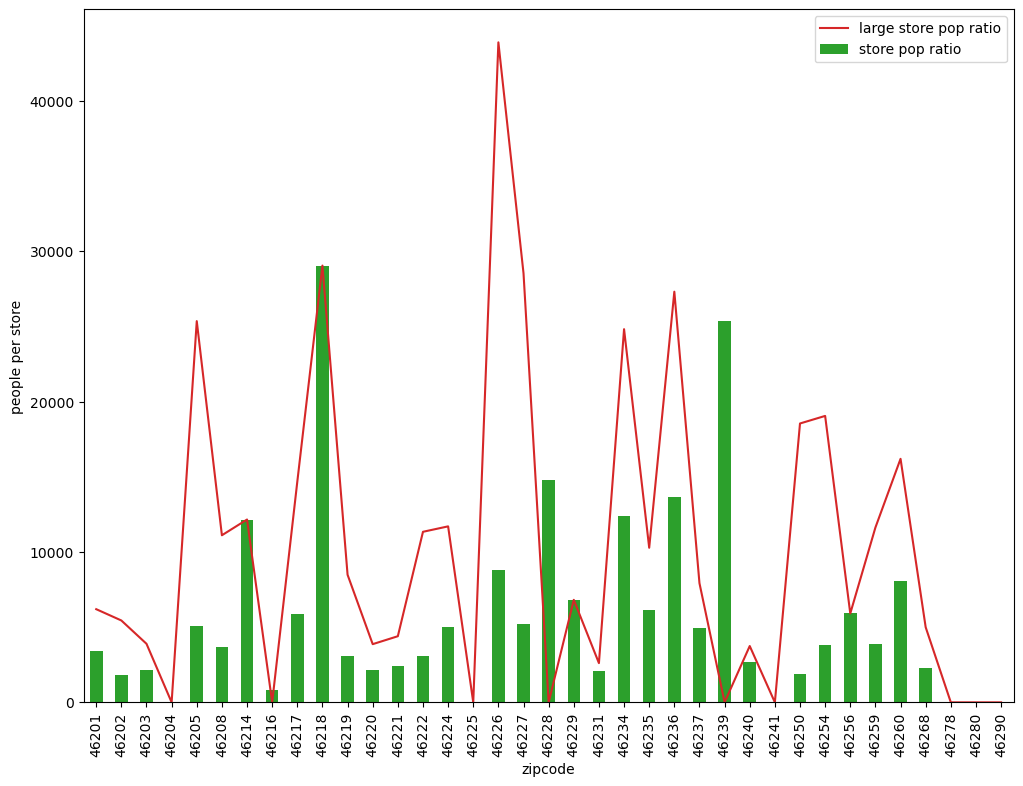

In [50]:
ax = inzip3.plot(x="zipcode", y="large store pop ratio", kind="line", color="C3")
inzip3.plot(x="zipcode", y="store pop ratio", kind="bar", ax=ax, color="C2")
ax.set_ylabel("people per store")

The above graph shows us how many people are being served by each store per square mile in the zip code areas. So where we have a very high red line we may have real issues with the number of people who have access to affordable fresh and healthy food. Even in zips with high green bars we can see that there are a lot of people being served by a smaller amount of venues so these would potentially be opportunity areas for new stores as well as areas of focus for government officials looking to develop business and serve the needs of the community.

Now lets use K Means Clustering to see how machine learning can help us categorize our zip codes based on the info we have collected.

In [51]:
#Frist we'll need to create a new df with just our numberical data

inzip4 = inzip3[['zipcode', 'median_household_income', 'population','store pop ratio','large store pop ratio']]


In [52]:
# set number of clusters
kclusters = 5

Indy_grouped_clustering = inzip4.drop('zipcode', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=42).fit(Indy_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

C:\Users\pvste\AppData\Local\Temp\ipykernel_26696\2313262226.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  Indy_grouped_clustering = inzip4.drop('zipcode', 1)


array([0, 0, 0, 1, 0, 0, 0, 1, 4, 3])

In [53]:
# add clustering labels
#inzip3.drop('Cluster Labels', 1, inplace=True)

inzip3.insert(0, 'Cluster Labels', kmeans.labels_)



When we look at the food desert problem from the standpoint of government ensuring that people have access to groceries, we can see that our clustering helps to illuminate the way the distribution of venues breaks down by median income level. Below we see that basically all of our 0 and 3 zips are on the lower side in terms of income. We can also see that in the lower income areas there tends to be a higher disparity between people per store and people per large store. Meaning that those in lower income zip codes tend to have easier access to smaller stores with more questionable access to a good variety of fresh healthy food. We would need to improve our granularity in the categorization of the venues to get better data on this but it certainly is pointing us in that direction.

In [54]:
inzip_sorted = inzip3.sort_values(by = 'median_household_income')
inzip_sorted[['Cluster Labels',  'zipcode', 'median_household_income','store pop ratio', 'large store pop ratio']]

,Cluster Labels,zipcode,median_household_income,store pop ratio,large store pop ratio
15,0,46225,24548.0,0.000,0.000
9,3,46218,25666.0,29046.880,29046.880
0,0,46201,26391.0,3442.198,6195.956
13,0,46222,27581.0,3093.349,11342.280
2,0,46203,30481.0,2163.738,3894.728
14,0,46224,30660.0,5015.927,11703.830
1,0,46202,31698.0,1814.740,5444.220
5,0,46208,31999.0,3703.920,11111.760
16,3,46226,34368.0,8778.572,43892.860
27,0,46241,34600.0,0.000,0.000


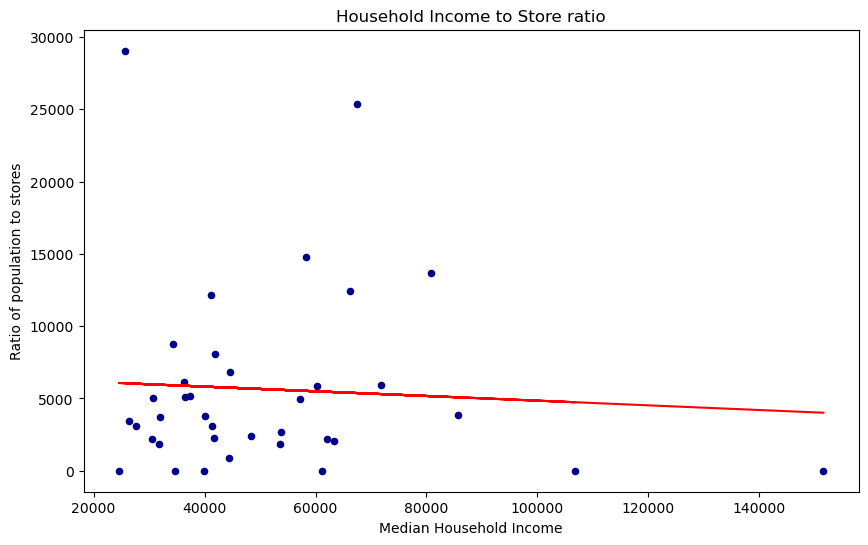

In [55]:
inzip_il = inzip3[['zipcode','median_household_income','store pop ratio']]

x = inzip_il['median_household_income']      
y = inzip_il['store pop ratio']     
fit = np.polyfit(x, y, deg=1)

fit

inzip_il.plot(kind='scatter', x='median_household_income', y='store pop ratio', figsize=(10, 6), color='darkblue')

plt.title('Household Income to Store ratio')
plt.xlabel('Median Household Income')
plt.ylabel('Ratio of population to stores')

plt.plot(x, fit[0] * x + fit[1], color='red') 
plt.annotate('y={0:.0f} x + {1:.0f}'.format(fit[0], fit[1]), xy=(0, 0))

plt.show()

We can see clearly that as median income goes up the ratio of people to stores goes down. Let's see how this compares to the ratio of people to large chain stores.

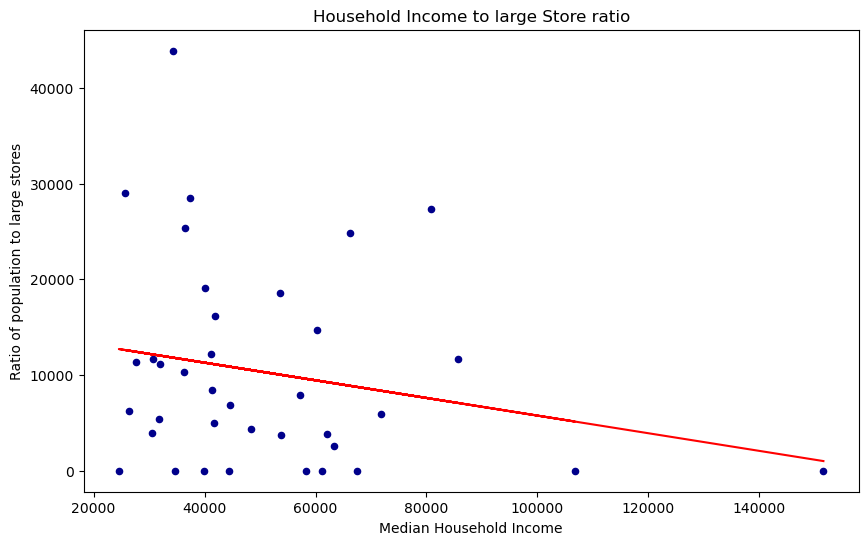

In [56]:
inzip_lc = inzip3[['zipcode','median_household_income','large store pop ratio']]

x = inzip_lc['median_household_income']      
y = inzip_lc['large store pop ratio']     
fit = np.polyfit(x, y, deg=1)

inzip_lc.plot(kind='scatter', x='median_household_income', y='large store pop ratio', figsize=(10, 6), color='darkblue')

plt.title('Household Income to large Store ratio')
plt.xlabel('Median Household Income')
plt.ylabel('Ratio of population to large stores')

plt.plot(x, fit[0] * x + fit[1], color='red') 
plt.annotate('y={0:.0f} x + {1:.0f}'.format(fit[0], fit[1]), xy=(0, 0))

plt.show()

The above plots show how as median income increases access to grocery stores increases and the relationship is even stronger when we just concider the larger stores. Now lets get a visual of how our clustering fits with our heatmap and see if we can find any interesting allignments.

In [57]:
Cluster_map = folium.Map(location=[latitude, longitude], zoom_start=11)

#set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(inzip3['Latitude'], inzip3['Longitude'], inzip3['zipcode'], inzip3['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(Cluster_map)

plugins.HeatMap(list_heat, radius = 30, min_opacity = 0.5, max_zoom = 13).add_to(Cluster_map)

Cluster_map

In [58]:
LrgClust_map = folium.Map(location=[latitude, longitude], zoom_start=11)

#set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(inzip3['Latitude'], inzip3['Longitude'], inzip3['zipcode'], inzip3['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(LrgClust_map)
    
plugins.HeatMap(lrg_heat, radius = 30, min_opacity = 0.5, max_zoom = 13).add_to(LrgClust_map)
    
LrgClust_map

### Conclusion
This project demonstrated how we can combine publicly available data in order to create striking visualizations. We further have shown how K Means clustering can help to group components within this data to pick up on trends and help distinguish between groups with many variables. This project should be a good starting point for anyone interested in visualizing four square or similar venue data, possibly changing the venue types to create heatmaps of business locations in a city or changing the parameters to plot other stats about venues. Also using the SK learn libraries it would be possible to expand the types of machine learning that are applied to this data to gain more insight into the trends and classifications that may be deduced about the makeup of a city.